## Overall EDA Findings

### Class Balance
There is class imbalance in this dataset ~13% 'bad'/~87% 'good'. While this isn't terrible, class imbalance can still lead to poor predictive accuracy in the infrequent class. For this model/dataset it is something to keep an eye on, especially after data cleaning. We want to make sure that our class imbalance doesn't get worse. 

### N/A Values
Columns in this dataset fall into one of four tiers of N/A counts: None, Rare, Semi-Rare, Numerous.
- Rare (<=35) N/A count rows can be dropped. I've shown below that there is heavy overlap in the rare column N/A values, meaning if one rare column is N/A, the liklihood that another rare column is N/A is _very_ high.
- There is only one semi-rare N/A count column: emp_title.
- There are three numerous tier columns: mths_since_last_record, mths_since_last_delinq, Notes.

### N/A Imputation
There are three obvious candidate columns for N/A imputation: mths_since_last_record, mths_since_last_delinq, emp_title.

**emp_title**

The easiest option here would be to set all N/A values to an empty string, however, this ignores the shape of the data.  The vast majority of rows have "long tail" employers (<=3 data points mapped to that employer). When building the logistic regression model, creating dummies for long tail employers will lead to over fitting. I'll likely have an "other" category for these employers.

**mths_since_last_record, mths_since_last_delinq**

There are two imputation strategies required, one for each model type (tree or regression based). For tree based models, I can likely choose a very large number or simply -1. The tree should be able to split on this, provided the features are meaningful for the model. For logistic regression, the imputation value is very important because we will be imposing bias on the data, based on what we choose. 

More analysis on this will come later.


### 'Commentary' Fields
Several fields have commentary (notes, 

### Outlier/Nonsensical Data


In [2]:
import datetime 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
df = pd.read_csv('../data/DR_Demo_Lending_Club.csv')

In [21]:
df.head()

Id  is_bad             emp_title emp_length home_ownership  annual_inc  \
0   1       0     Time Warner Cable         10       MORTGAGE     50000.0   
1   2       0     Ottawa University          1           RENT     39216.0   
2   3       0        Kennedy Wilson          4           RENT     65000.0   
3   4       0    TOWN OF PLATTEKILL         10       MORTGAGE     57500.0   
4   5       0  Belmont Correctional         10       MORTGAGE     50004.0   

  verification_status pymnt_plan  \
0        not verified          n   
1        not verified          n   
2        not verified          n   
3        not verified          n   
4   VERIFIED - income          n   

                                               Notes         purpose_cat  ...  \
0                                                NaN             medical  ...   
1    Borrower added on 04/14/11 > I will be using...  debt consolidation  ...   
2                                                NaN         credit card  ...   
3                                                NaN  debt consolidation  ...   
4  I want to consolidate my debt, pay for a vacat...  debt consolidation  ...   

  open_acc pub_rec revol_bal  revol_util  total_acc initial_list_status  \
0     15.0     0.0     12087        12.1       44.0                   f   
1      4.0     0.0     10114        64.0        5.0                   f   
2      4.0     0.0        81         0.6        8.0                   f   
3      6.0     0.0     10030        37.1       23.0                   f   
4      8.0     0.0     10740        40.4       21.0                   f   

   collections_12_mths_ex_med  mths_since_last_major_derog  policy_code  \
0                         0.0                            1          PC4   
1                         0.0                            2          PC1   
2                         0.0                            3          PC4   
3                         0.0                            2          PC2   
4                         0.0                            3          PC3   

   days_since_earliest_cr_line  
0                       9639.0  
1                       4921.0  
2                      17858.0  
3                      13383.0  
4                       7144.0  

[5 rows x 29 columns]

## Lightweight Cleanup

In [4]:
## Casting earliest_cr_line to a datetime, then calculating days since.
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])
current_date = datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
df['days_since_earliest_cr_line'] = (current_date - df['earliest_cr_line']).dt.days

## Data Types

In [5]:
df.dtypes

Id                                      int64
is_bad                                  int64
emp_title                              object
emp_length                             object
home_ownership                         object
annual_inc                            float64
verification_status                    object
pymnt_plan                             object
Notes                                  object
purpose_cat                            object
purpose                                object
zip_code                               object
addr_state                             object
debt_to_income                        float64
delinq_2yrs                           float64
earliest_cr_line               datetime64[ns]
inq_last_6mths                        float64
mths_since_last_delinq                float64
mths_since_last_record                float64
open_acc                              float64
pub_rec                               float64
revol_bal                         

## Summarize Data

### Numeric Data

In [6]:
## Numeric Data
df.describe()

Id        is_bad     annual_inc  debt_to_income  delinq_2yrs  \
count  10000.00000  10000.000000    9999.000000    10000.000000  9995.000000   
mean    5000.50000      0.129500   68203.011539       13.338704     0.148174   
std     2886.89568      0.335769   48590.252757        6.754212     0.506270   
min        1.00000      0.000000    2000.000000        0.000000     0.000000   
25%     2500.75000      0.000000   40000.000000        8.160000     0.000000   
50%     5000.50000      0.000000   58000.000000       13.410000     0.000000   
75%     7500.25000      0.000000   82000.000000       18.692500     0.000000   
max    10000.00000      1.000000  900000.000000       29.990000    11.000000   

       inq_last_6mths  mths_since_last_delinq  mths_since_last_record  \
count     9995.000000             3684.000000              840.000000   
mean         1.066933               35.890337               61.652381   
std          1.476052               22.361443               46.189619   
min          0.000000                0.000000                0.000000   
25%          0.000000               18.000000                0.000000   
50%          1.000000               34.000000               86.000000   
75%          2.000000               53.000000              101.000000   
max         25.000000              120.000000              119.000000   

          open_acc      pub_rec     revol_bal   revol_util    total_acc  \
count  9995.000000  9995.000000  1.000000e+04  9974.000000  9995.000000   
mean      9.334567     0.060130  1.427101e+04    48.450771    22.011306   
std       4.526590     0.251245  2.543791e+04    28.220557    11.709400   
min       1.000000     0.000000  0.000000e+00     0.000000     1.000000   
25%       6.000000     0.000000  3.524500e+03    25.000000    13.000000   
50%       9.000000     0.000000  8.645500e+03    48.700000    20.000000   
75%      12.000000     0.000000  1.695225e+04    71.800000    29.000000   
max      39.000000     3.000000  1.207359e+06   100.600000    90.000000   

       collections_12_mths_ex_med  mths_since_last_major_derog  \
count                      9968.0                 10000.000000   
mean                          0.0                     2.002200   
std                           0.0                     0.810963   
min                           0.0                     1.000000   
25%                           0.0                     1.000000   
50%                           0.0                     2.000000   
75%                           0.0                     3.000000   
max                           0.0                     3.000000   

       days_since_earliest_cr_line  
count                  9995.000000  
mean                   8092.297149  
std                    2497.137555  
min                    3825.000000  
25%                    6413.000000  
50%                    7631.000000  
75%                    9243.000000  
max                   24980.000000

### Categorical Data

In [7]:
def groupby_and_count(df, col):
    return df.groupby(col).count().sort_values('Id', ascending=False)['Id']

In [15]:
## Employer
employer_dist = groupby_and_count(df, 'emp_title')
employer_dist.head(10)

emp_title
US Army                    36
Bank of America            23
IBM                        22
USAF                       17
United States Air Force    16
US Navy                    15
Wells Fargo                14
AT&T                       14
Self Employed              14
U.S. Army                  14
Name: Id, dtype: int64

In [20]:
## Employer Distribution
sum(employer_dist[employer_dist.values <= 3].values)

8584

In [8]:
## Home Ownership
groupby_and_count(df, 'home_ownership')

home_ownership
RENT        4745
MORTGAGE    4445
OWN          775
OTHER         34
NONE           1
Name: Id, dtype: int64

In [9]:
## Verification Status
groupby_and_count(df, 'verification_status')

verification_status
not verified                4367
VERIFIED - income           3214
VERIFIED - income source    2419
Name: Id, dtype: int64

In [10]:
## Payment Plan
groupby_and_count(df, 'pymnt_plan')

pymnt_plan
n    9998
y       2
Name: Id, dtype: int64

In [11]:
## Payment Plan
groupby_and_count(df, 'initial_list_status')

initial_list_status
f    9983
m      17
Name: Id, dtype: int64

In [12]:
## Customer State
groupby_and_count(df, 'addr_state').head()

addr_state
CA    1748
NY     958
FL     714
TX     700
NJ     482
Name: Id, dtype: int64

In [13]:
## Purpose Category
groupby_and_count(df, 'purpose_cat').head(10)

purpose_cat
debt consolidation    4454
credit card           1273
other                 1026
home improvement       800
major purchase         546
small business         461
car                    349
wedding                250
medical                183
moving                 159
Name: Id, dtype: int64

In [14]:
## Purpose
groupby_and_count(df, 'purpose').head(10)

purpose
Debt Consolidation           530
Debt Consolidation Loan      412
Personal Loan                143
Consolidation                125
debt consolidation           116
Home Improvement             106
Small Business Loan           95
Personal                      89
Credit Card Consolidation     87
Debt consolidation            72
Name: Id, dtype: int64

## Class Balance

Evidenced below, we have roughly a 10/90 class imbalance. Will likely need to do some sort of re-sampling.

In [15]:
print('Count of "is_bad" data points:         {}'.format(len(df[df['is_bad']==1])))
print('Percent of total "is_bad" data points: {}'.format((len(df[df['is_bad']==1]))/len(df)))

print()
print('Count of "is_ok" data points:         {}'.format(len(df[df['is_bad']==0])))
print('Percent of total "is_ok" data points: {}'.format((len(df[df['is_bad']==0]))/len(df)))


Count of "is_bad" data points:         1295
Percent of total "is_bad" data points: 0.1295

Count of "is_ok" data points:         8705
Percent of total "is_ok" data points: 0.8705


## N/A Value Analysis

In [28]:
na_counts = pd.DataFrame()
for col in df:
    na_counts = na_counts.append(
        pd.DataFrame(
            {
                'column':col,
                'na_count':len(df[df.isna()[col]])
            }, index=[0]
        )
    )
na_counts.reset_index(drop=True).sort_values('na_count', ascending=False)

column  na_count
18       mths_since_last_record      9160
17       mths_since_last_delinq      6316
8                         Notes      3167
2                     emp_title       592
25   collections_12_mths_ex_med        32
22                   revol_util        26
14                  delinq_2yrs         5
15             earliest_cr_line         5
23                    total_acc         5
20                      pub_rec         5
19                     open_acc         5
16               inq_last_6mths         5
28  days_since_earliest_cr_line         5
10                      purpose         4
5                    annual_inc         1
13               debt_to_income         0
1                        is_bad         0
12                   addr_state         0
11                     zip_code         0
9                   purpose_cat         0
7                    pymnt_plan         0
6           verification_status         0
21                    revol_bal         0
4                home_ownership         0
24          initial_list_status         0
3                    emp_length         0
26  mths_since_last_major_derog         0
27                  policy_code         0
0                            Id         0

### NA Counts and Imputation Ideas

- **emp_title**
    - NA Count: 592
    - Imputation: Could set to '', however that might be an issue. Maybe we can infer a value? Unlikely. Dropping is risky, as it represents ~5% of our data.
- **annual_inc**
    - NA Count: 1
    - Imputation: I will drop this row.
- **Notes**
    - NA Count: 3167
    - Imputation: Unsure of the importance of this particular feature. Not going to worry about imputation at this point.
- **purpose**
    - NA Count: 4
    - Imputation: Unsure of the importance of this particular feature. Given the number of points, will likely drop.
- **delinq_2yrs, earliest_cr_line, inq_last_6mths, open_acc, pub_rec, total_acc**
    - NA Count: 5 Total across all of these columns.
    - Imputation: Will drop.
- **mths_since_last_delinq, mths_since_last_record**
    - Count: **A lot.**
    - Imputation: There are three things that come to mind: (1) Set these values equal to a really high value, (2) set them equal to -1, (3) set them equal to number of months since earliest_cr_line.                  
- **revol_util**
    - NA Count: 26
- **collections_12_mths_ex_med**
    - NA Count: 32
    - Imputation: For both this, and the value above, I can likely use some mean, median imputation.

## Plotting Numerical Data

In [17]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_df = df.select_dtypes(include=numerics).drop(['Id'], axis=1)

/Users/jakeweholt/.virtualenvs/DR_TH/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jakeweholt/.virtualenvs/DR_TH/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


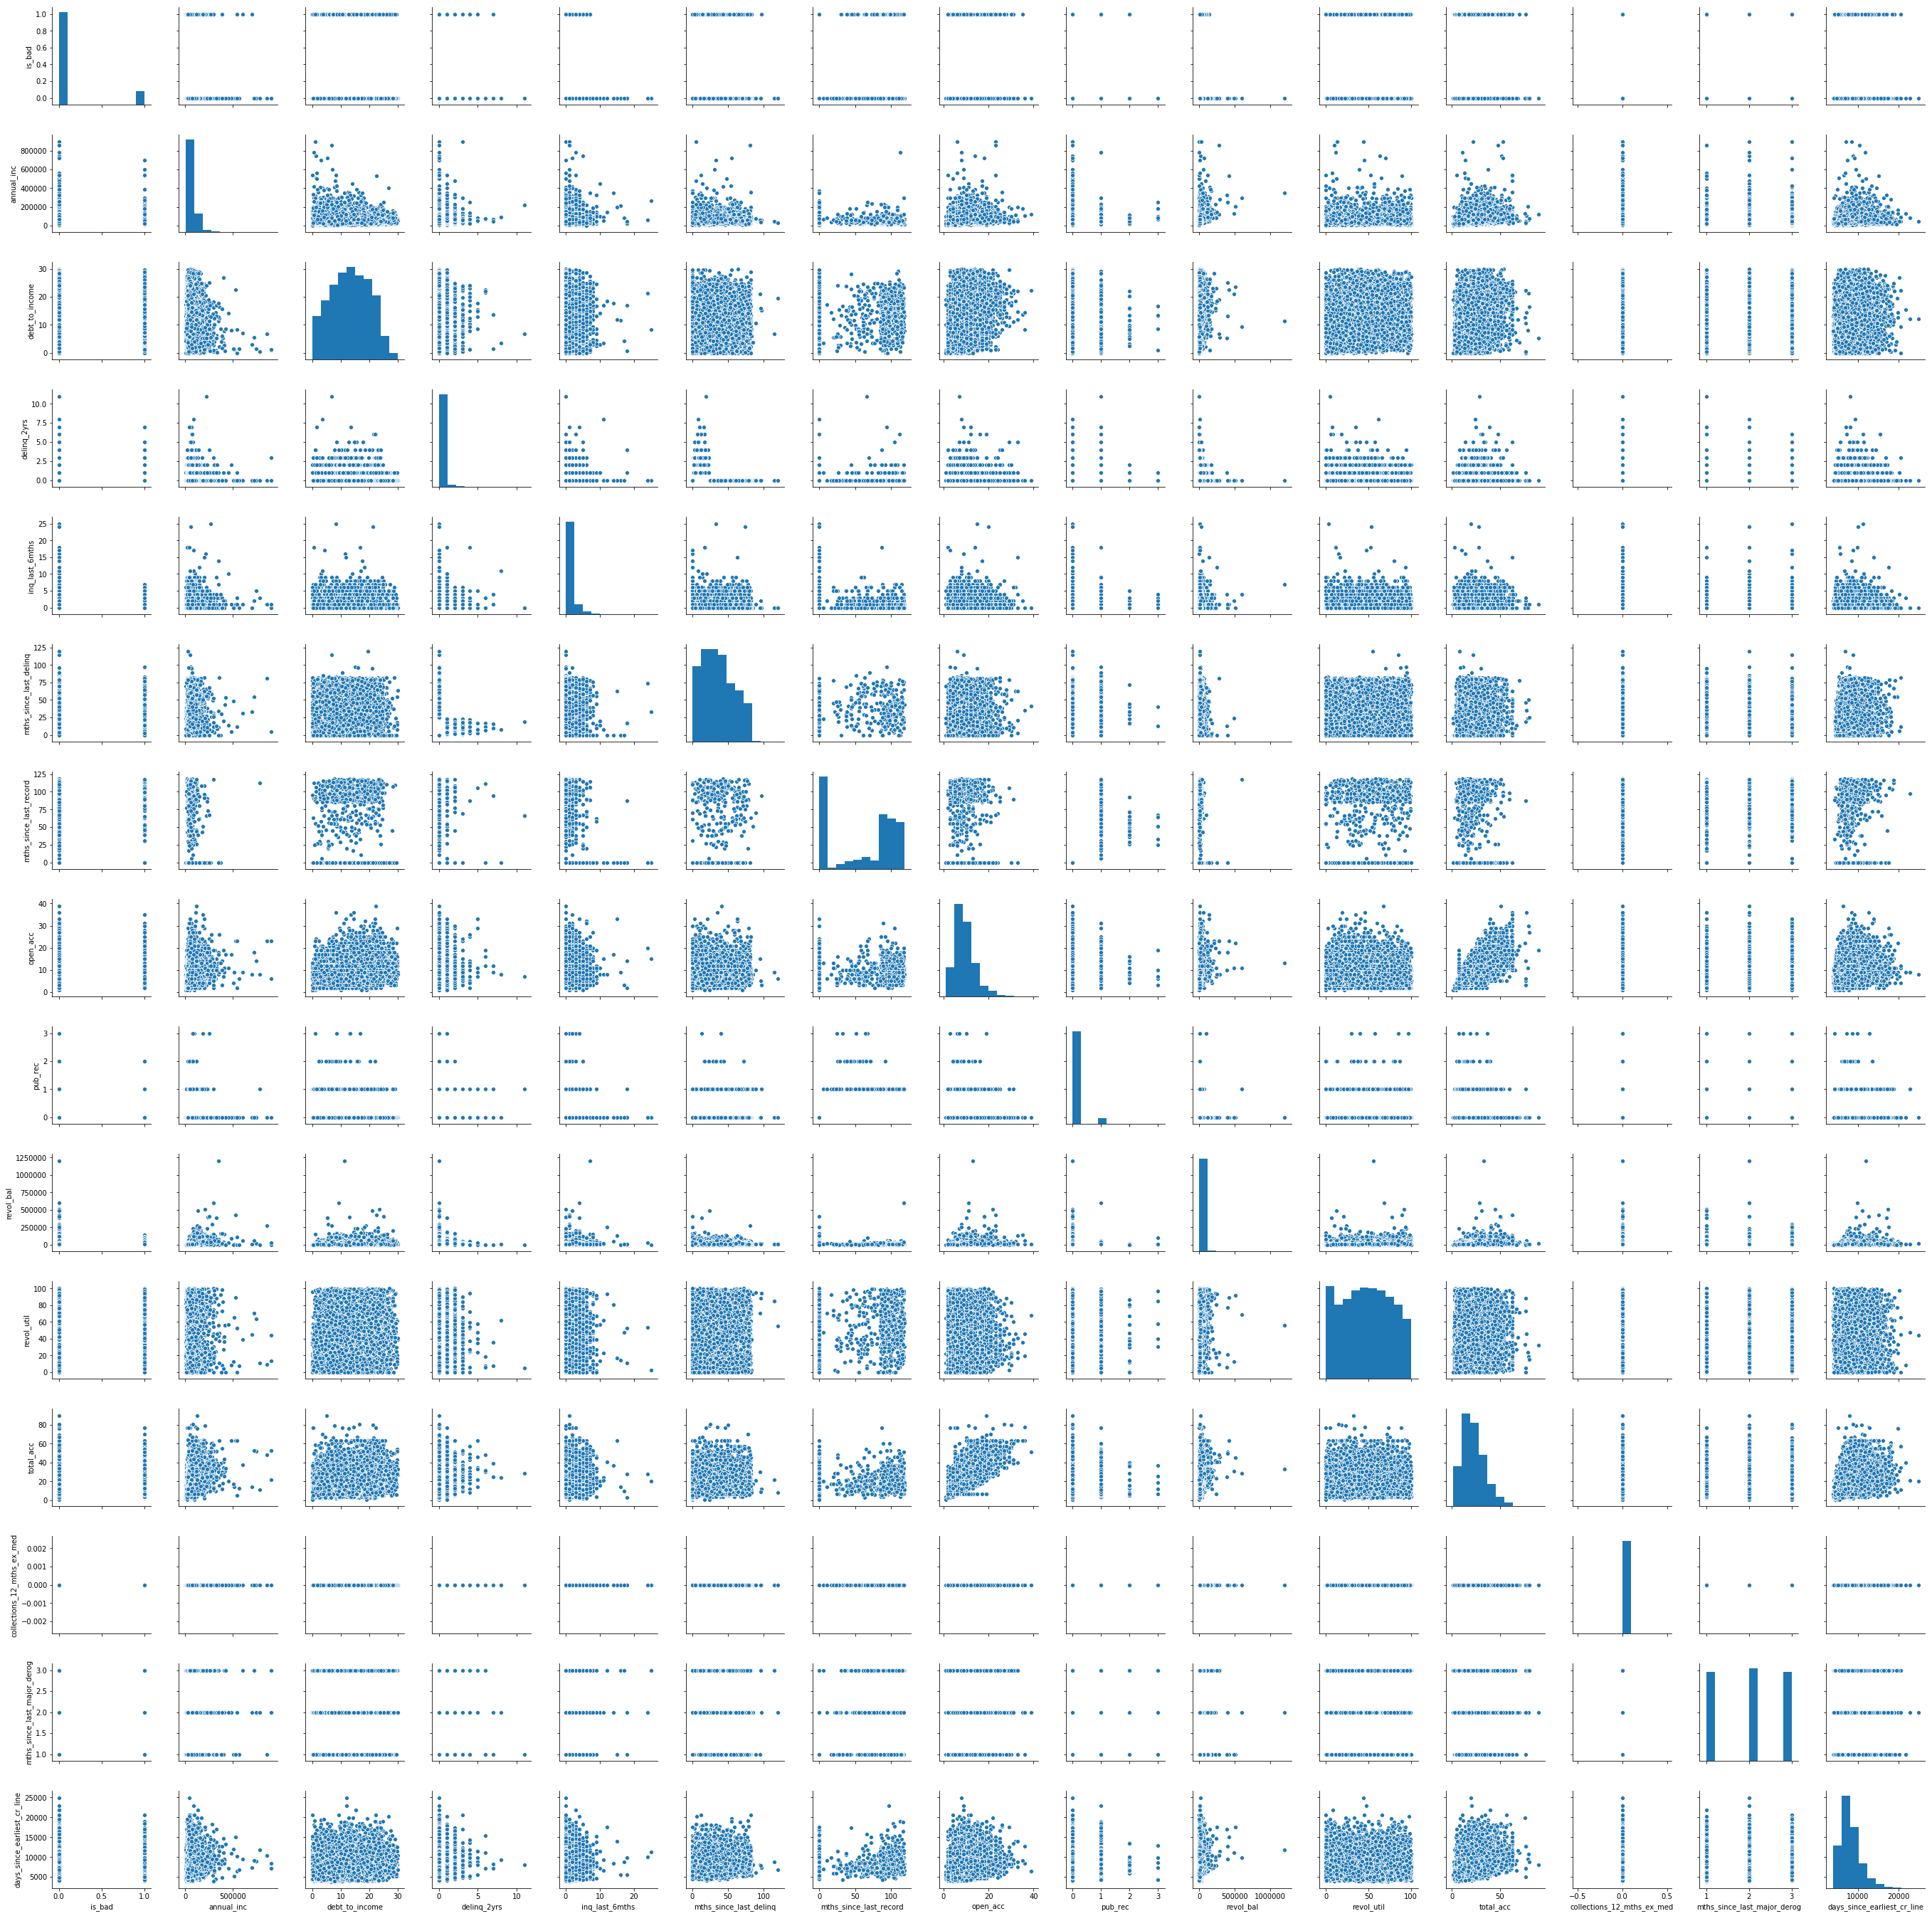

In [18]:
sns.pairplot(numerical_df)

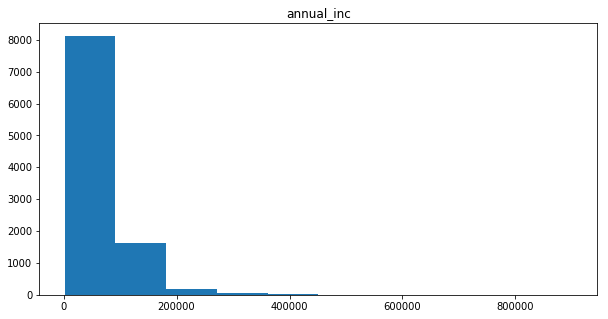

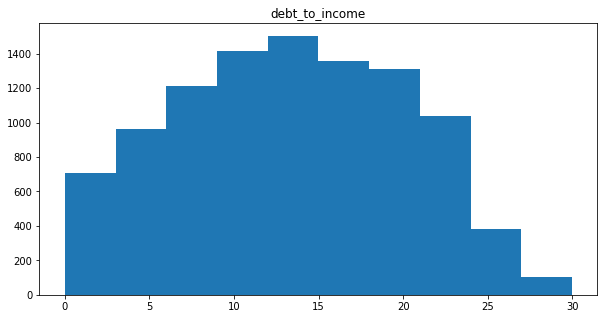

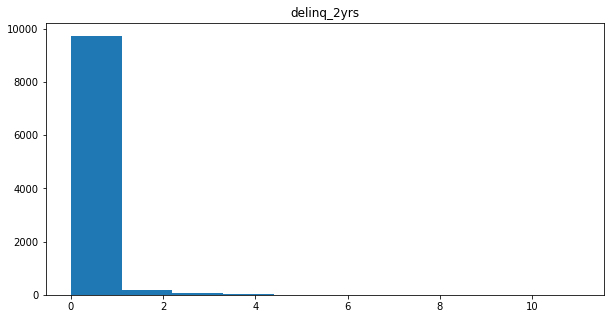

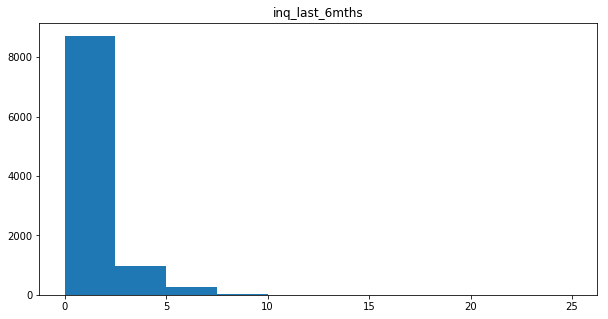

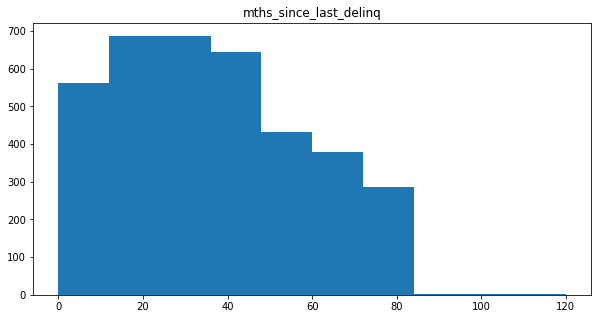

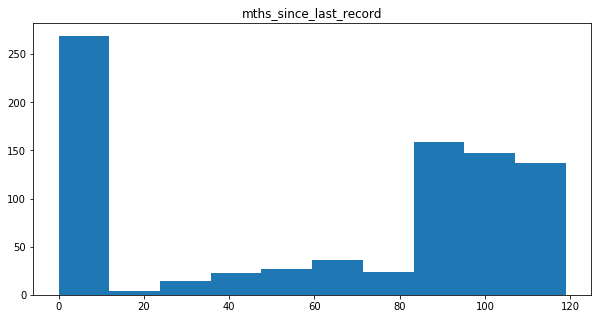

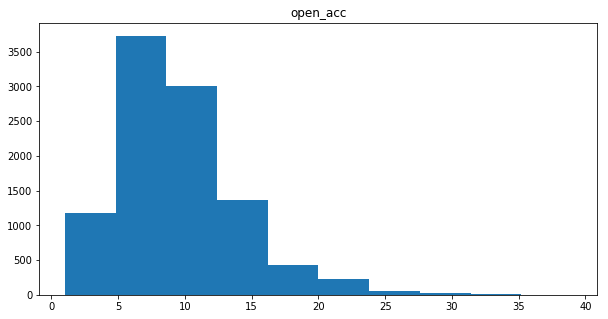

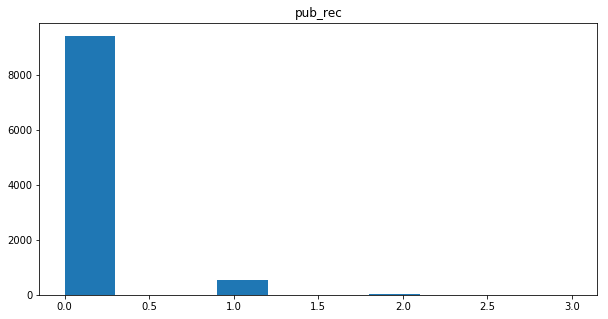

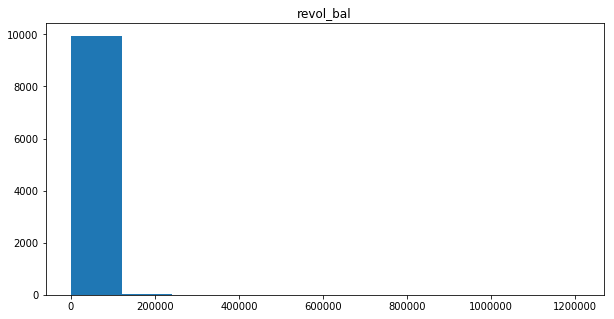

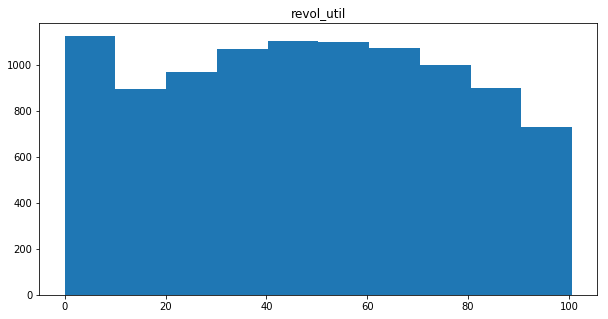

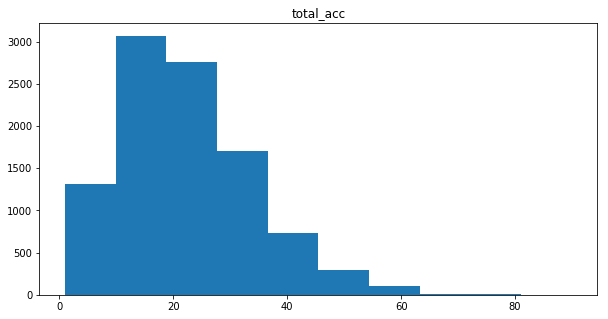

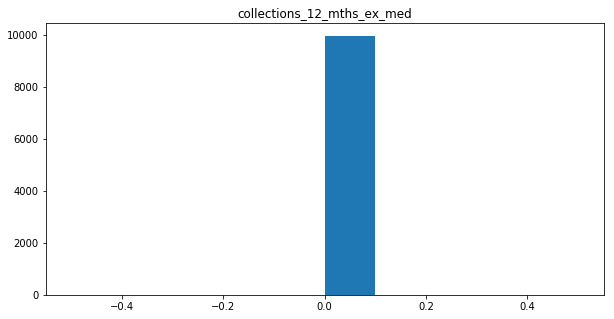

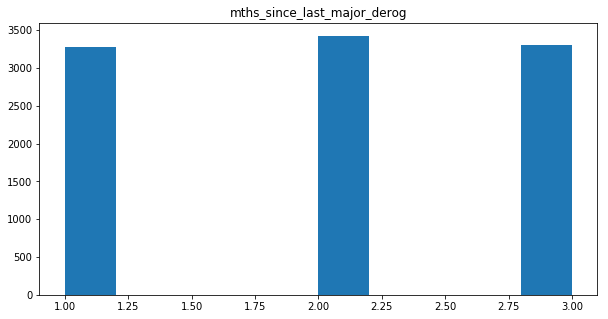

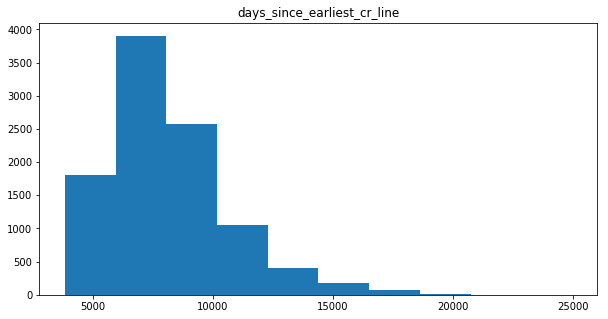

In [19]:
numerical_df = numerical_df.drop(['is_bad'], axis=1)
for col in numerical_df:
    plt.figure(figsize=[10,5])
    plt.hist(numerical_df[col])
    plt.title(col)

## Extreme Values

### Outliers

In [20]:
## These are good.
df.sort_values('annual_inc', ascending=False)['annual_inc'].head()

240     900000.0
7973    900000.0
8933    860000.0
7425    780000.0
1296    744000.0
Name: annual_inc, dtype: float64

In [21]:
## The Max revolving balance is over double the next closest value, it can likely be dropped because it's an outlier.
df.sort_values('revol_bal', ascending=False)['revol_bal'].head()

159     1207359
4695     602519
2835     508961
5480     487589
7453     423189
Name: revol_bal, dtype: int64

In [22]:
## 11 might be an outlier, given the distribution of the delinq_2yrs column. Undetermined at this point.
df.sort_values('delinq_2yrs', ascending=False)['delinq_2yrs'].head()

4014    11.0
6624     8.0
8443     7.0
699      7.0
2432     6.0
Name: delinq_2yrs, dtype: float64

In [26]:
## This seems pretty reasonable.
df.sort_values('earliest_cr_line', ascending=True)['earliest_cr_line'].head()

5085   1950-12-01
6618   1956-09-01
5258   1959-06-01
684    1962-09-01
3528   1962-09-01
Name: earliest_cr_line, dtype: datetime64[ns]

### Non-sensical Data

In [24]:
## Why is this value > 100? 
## Col Definition: Loan applicant’s percentage utilization of their revolving 
##                 credit facility, rounded to one decimal place
df[df['revol_util'] > 100]

Id  is_bad                 emp_title emp_length home_ownership  \
9655  9656       0  Colorado School of Mines          3       MORTGAGE   

      annual_inc verification_status pymnt_plan  \
9655     32000.0        not verified          n   

                                                  Notes         purpose_cat  \
9655  I am finishing up my Ph.D. in chemical enginee...  debt consolidation   

      ... open_acc pub_rec revol_bal  revol_util  total_acc  \
9655  ...     18.0     0.0      2012       100.6       23.0   

     initial_list_status  collections_12_mths_ex_med  \
9655                   f                         0.0   

      mths_since_last_major_derog  policy_code  days_since_earliest_cr_line  
9655                            1          PC2                       7601.0  

[1 rows x 29 columns]

In [25]:
## This column can be dropped. It is either 0 or NA.
len(df[(df['collections_12_mths_ex_med'] == 0) | (df.isna()['collections_12_mths_ex_med'])]) == len(df)

True